In [1]:
import uproot
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Tree = uproot.open("qqZvvHbbJ_PwPy8MINLO-FSR.root")["Nominal"]

In [3]:
Tree.show()

nTags                      (no streamer)              asdtype('>i4')
nTaus                      (no streamer)              asdtype('>i4')
b1Flav                     (no streamer)              asdtype('>i4')
b2Flav                     (no streamer)              asdtype('>i4')
j3Flav                     (no streamer)              asdtype('>i4')
FSRflag                    (no streamer)              asdtype('>i4')
nFatJets                   (no streamer)              asdtype('>i4')
nTrkJets                   (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
ChannelNumber              (no streamer)              asdtype('>i4')
nbTagsOutsideFJ            (no streamer)              asdtype('>i4')
HT                         (no streamer)              asdtype('>f8')
nJ                         (no streamer)              asdtype('>f8')
MET                        (no streamer)              asdtype('>f8')
MPT                        (no str

In [4]:
DataFrame = Tree.pandas.df(["nJ", 
                            "mB1", "etaB1", "pTB1", "phiB1",
                            "mB2", "etaB2", "pTB2", "phiB2",
                            "mJ3", "etaJ3", "pTJ3", "phiJ3",
                            "MV2c10B1", "MV2c10B2","MV2c10J3",
                            "mBB","mBBJ",
                            "FSRflag"])

Create a DataFrame for only the 3 jet category:

In [5]:
DataFrame3jet = DataFrame[DataFrame["nJ"] == 3]
DataFrame3jet.head()

nJ        mB1     etaB1        pTB1     phiB1        mB2     etaB2  \
1  3.0  16.091217 -1.032608  183.838156 -2.855371  11.614605 -1.646256   
3  3.0  11.263318  1.614670   92.666523  0.946947  10.679085  0.888882   
4  3.0  14.080425 -0.556389  154.664187 -2.706695   8.847122  0.567556   
6  3.0  21.230221  0.897894  146.218266  2.051119  10.897438  0.250261   
8  3.0  16.140849  1.367030  178.595969 -1.263367  11.281945  0.865182   

         pTB2     phiB2        mJ3     etaJ3        pTJ3     phiJ3  MV2c10B1  \
1  115.164016 -2.316197   4.219567 -1.867909   21.149043  1.671657  0.993121   
3   62.688605  0.201407   5.037271  0.276991   25.526467 -0.144470  0.992125   
4   53.106539 -2.198815   3.048540  1.418607   20.098998 -0.341676  0.999149   
6   55.542168  0.843640  12.440214  1.269122  103.450648  0.328651 -0.780321   
8  141.896641 -0.782471   7.724980  3.227335   49.440676 -0.840956 -0.221259   

   MV2c10B2  MV2c10J3         mBB        mBBJ  FSRflag  
1  0.997642 -0.868425  122.593008  188.667969        1  
3 -0.900604 -0.176656   82.918312  124.590430        3  
4  0.999417 -0.791016  118.995266  212.488531        2  
6  0.939635 -0.228354  122.971516  247.471453        3  
8  0.999933 -0.538816  114.157008  342.201094        2

Add PtRel var:

In [6]:
pd.options.mode.chained_assignment = None #To remove waring
DataFrame3jet['pTRelB1J3'] = DataFrame3jet["pTB1"] / DataFrame3jet["pTJ3"]
DataFrame3jet['pTRelB2J3'] = DataFrame3jet["pTB2"] / DataFrame3jet["pTJ3"]

Drop FSRflag 1 (jet with TruthPt < 25 GeV than cannot be classified):

In [7]:
DataFrame3jet = DataFrame3jet[DataFrame3jet.FSRflag != 1]
DataFrame3jet.head()

nJ        mB1     etaB1        pTB1     phiB1        mB2     etaB2  \
3  3.0  11.263318  1.614670   92.666523  0.946947  10.679085  0.888882   
4  3.0  14.080425 -0.556389  154.664187 -2.706695   8.847122  0.567556   
6  3.0  21.230221  0.897894  146.218266  2.051119  10.897438  0.250261   
8  3.0  16.140849  1.367030  178.595969 -1.263367  11.281945  0.865182   
9  3.0  18.330619 -0.921140   94.400547  1.548463  16.822561 -0.418769   

         pTB2     phiB2        mJ3    ...            pTJ3     phiJ3  MV2c10B1  \
3   62.688605  0.201407   5.037271    ...       25.526467 -0.144470  0.992125   
4   53.106539 -2.198815   3.048540    ...       20.098998 -0.341676  0.999149   
6   55.542168  0.843640  12.440214    ...      103.450648  0.328651 -0.780321   
8  141.896641 -0.782471   7.724980    ...       49.440676 -0.840956 -0.221259   
9   78.553773  0.939842  12.805050    ...       86.007117  0.849800 -0.792260   

   MV2c10B2  MV2c10J3         mBB        mBBJ  FSRflag  pTRelB1J3  pTRelB2J3  
3 -0.900604 -0.176656   82.918312  124.590430        3   3.630213   2.455828  
4  0.999417 -0.791016  118.995266  212.488531        2   7.695119   2.642248  
6  0.939635 -0.228354  122.971516  247.471453        3   1.413411   0.536895  
8  0.999933 -0.538816  114.157008  342.201094        2   3.612329   2.870038  
9  0.992107  0.492609   76.522875  117.512992        3   1.097590   0.913340  

[5 rows x 21 columns]

Modify FSRflag column (FSR = 1, Bkg = 0):

In [8]:
DataFrame3jet['FSRflag'] = DataFrame3jet['FSRflag'] == 3
DataFrame3jet.head()

nJ        mB1     etaB1        pTB1     phiB1        mB2     etaB2  \
3  3.0  11.263318  1.614670   92.666523  0.946947  10.679085  0.888882   
4  3.0  14.080425 -0.556389  154.664187 -2.706695   8.847122  0.567556   
6  3.0  21.230221  0.897894  146.218266  2.051119  10.897438  0.250261   
8  3.0  16.140849  1.367030  178.595969 -1.263367  11.281945  0.865182   
9  3.0  18.330619 -0.921140   94.400547  1.548463  16.822561 -0.418769   

         pTB2     phiB2        mJ3    ...            pTJ3     phiJ3  MV2c10B1  \
3   62.688605  0.201407   5.037271    ...       25.526467 -0.144470  0.992125   
4   53.106539 -2.198815   3.048540    ...       20.098998 -0.341676  0.999149   
6   55.542168  0.843640  12.440214    ...      103.450648  0.328651 -0.780321   
8  141.896641 -0.782471   7.724980    ...       49.440676 -0.840956 -0.221259   
9   78.553773  0.939842  12.805050    ...       86.007117  0.849800 -0.792260   

   MV2c10B2  MV2c10J3         mBB        mBBJ  FSRflag  pTRelB1J3  pTRelB2J3  
3 -0.900604 -0.176656   82.918312  124.590430     True   3.630213   2.455828  
4  0.999417 -0.791016  118.995266  212.488531    False   7.695119   2.642248  
6  0.939635 -0.228354  122.971516  247.471453     True   1.413411   0.536895  
8  0.999933 -0.538816  114.157008  342.201094    False   3.612329   2.870038  
9  0.992107  0.492609   76.522875  117.512992     True   1.097590   0.913340  

[5 rows x 21 columns]

In [9]:
DataFrame3jet_train, DataFrame3jet_test = train_test_split(DataFrame3jet, test_size=0.33)

In [10]:
X3jet_train = DataFrame3jet_train[["mB1", "etaB1", "pTB1", "phiB1",
                            "mB2", "etaB2", "pTB2", "phiB2",
                            "mJ3", "etaJ3", "pTJ3", "phiJ3",
                            "MV2c10B1", "MV2c10B2","MV2c10J3",
                            "mBB","mBBJ",
                            "pTRelB1J3","pTRelB2J3"]].as_matrix()
Y3jet_train = DataFrame3jet_train[["FSRflag"]].as_matrix()


X3jet_test = DataFrame3jet_test[["mB1", "etaB1", "pTB1", "phiB1",
                            "mB2", "etaB2", "pTB2", "phiB2",
                            "mJ3", "etaJ3", "pTJ3", "phiJ3",
                            "MV2c10B1", "MV2c10B2","MV2c10J3",
                            "mBB","mBBJ",
                            "pTRelB1J3","pTRelB2J3"]].as_matrix()
Y3jet_test = DataFrame3jet_test[["FSRflag"]].as_matrix()

In [11]:
model = XGBClassifier(objective='multi:softprob', num_class = 2, max_depth=6, verbose=True)

In [12]:
model.fit(X3jet_train, Y3jet_train.ravel(), 
          eval_set=[(X3jet_train, Y3jet_train.ravel()), (X3jet_test, Y3jet_test.ravel())],
          verbose=True
         ) 

[0]	validation_0-merror:0.138832	validation_1-merror:0.143039
[1]	validation_0-merror:0.135421	validation_1-merror:0.139979
[2]	validation_0-merror:0.132377	validation_1-merror:0.136749
[3]	validation_0-merror:0.130375	validation_1-merror:0.135684
[4]	validation_0-merror:0.129592	validation_1-merror:0.134644
[5]	validation_0-merror:0.128567	validation_1-merror:0.133236
[6]	validation_0-merror:0.127795	validation_1-merror:0.132539
[7]	validation_0-merror:0.127337	validation_1-merror:0.132025
[8]	validation_0-merror:0.126921	validation_1-merror:0.13118
[9]	validation_0-merror:0.1263	validation_1-merror:0.130213
[10]	validation_0-merror:0.1253	validation_1-merror:0.129712
[11]	validation_0-merror:0.124751	validation_1-merror:0.129296
[12]	validation_0-merror:0.124558	validation_1-merror:0.128745
[13]	validation_0-merror:0.123751	validation_1-merror:0.128231
[14]	validation_0-merror:0.123142	validation_1-merror:0.127472
[15]	validation_0-merror:0.122491	validation_1-merror:0.127423
[16]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=2, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbose=True)

In [13]:
Y3jet_pred = model.predict_proba(X3jet_test)

Just a quick (and unfair) check at the MVA:

In [14]:
mBBJ_aboveMVAcut = []
for i, val in enumerate(Y3jet_pred):
    if val[1] > 0.8:
        mBBJ_aboveMVAcut.append(X3jet_test[i][16]) #16:mBBJ

203.66068649084457
161.11985575732962


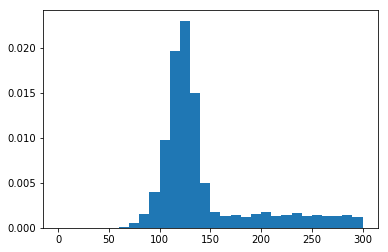

In [15]:
x = np.asarray(mBBJ_aboveMVAcut)
p = plt.hist(x, normed=True, bins=30, range=(0,300))
print(x.mean())
print(x.std())